In [1]:
%pip install pandas
%pip install numpy
%pip install seaborn
%pip install matplotlib
%pip install scipy
%pip install scikit-posthocs
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kstest, norm, ttest_ind, mannwhitneyu
import scikit_posthocs as sp
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
import statsmodels.api as sm


In [3]:
df = pd.read_csv(r"D:\z. AB testing\2. Marketing AB Testing\marketing_AB.csv")
print('df.info(): \n')
df.info()
print(' \n df.isna().sum():')
df.isna().sum()
print(' \n df.describe():')
df.describe()

df.info(): 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB
 
 df.isna().sum():
 
 df.describe():


,Unnamed: 0,user id,total ads,most ads hour
count,588101.000000,5.881010e+05,588101.000000,588101.000000
mean,294050.000000,1.310692e+06,24.820876,14.469061
std,169770.279668,2.022260e+05,43.715181,4.834634
min,0.000000,9.000000e+05,1.000000,0.000000
25%,147025.000000,1.143190e+06,4.000000,11.000000
50%,294050.000000,1.313725e+06,13.000000,14.000000
75%,441075.000000,1.484088e+06,27.000000,18.000000
max,588100.000000,1.654483e+06,2065.000000,23.000000


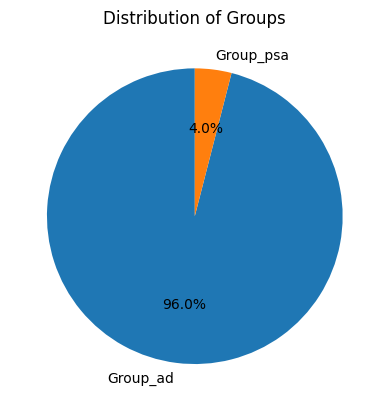

In [4]:
test_group_ad   = (df['test group'] == 'ad').sum()
test_group_psa  = (df['test group'] == 'psa').sum()

plt.pie([test_group_ad, test_group_psa], labels=['Group_ad', 'Group_psa'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Groups')
plt.show()

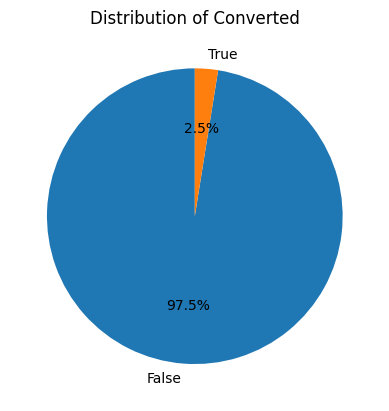

In [5]:
group_counts = df['converted'].value_counts()


plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Converted')
plt.show()

converted
False    550154
True      14423
Name: count, dtype: int64


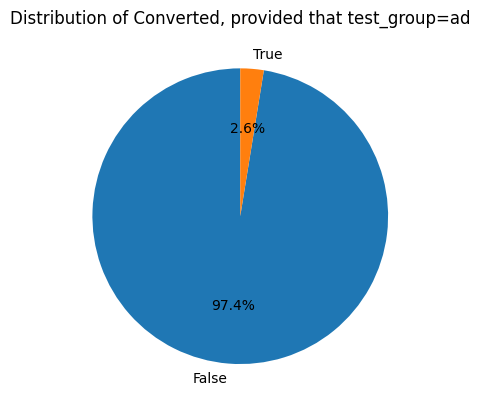

In [6]:
# Let's have at conversions in ads test group ONLY
count_Converted_when_ad = df.loc[df['test group'] == 'ad', 'converted'].value_counts()
print(count_Converted_when_ad)

plt.pie(count_Converted_when_ad, labels=count_Converted_when_ad.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Converted, provided that test_group=ad')
plt.show()

converted
False    23104
True       420
Name: count, dtype: int64


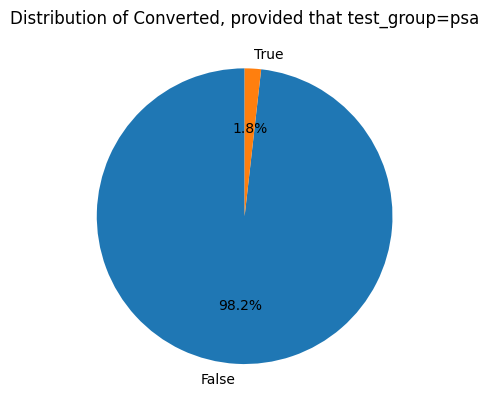

In [7]:
# Let's have at conversions in psa test group ONLY (if any)
count_Converted_when_psa = df.loc[df['test group'] == 'psa', 'converted'].value_counts()
print(count_Converted_when_psa)

plt.pie(count_Converted_when_psa, labels=count_Converted_when_psa.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Converted, provided that test_group=psa')
plt.show()

Apparently , here is conversion in psa test group. it was not obvious from the description of the case, so I'm glad we checked it.

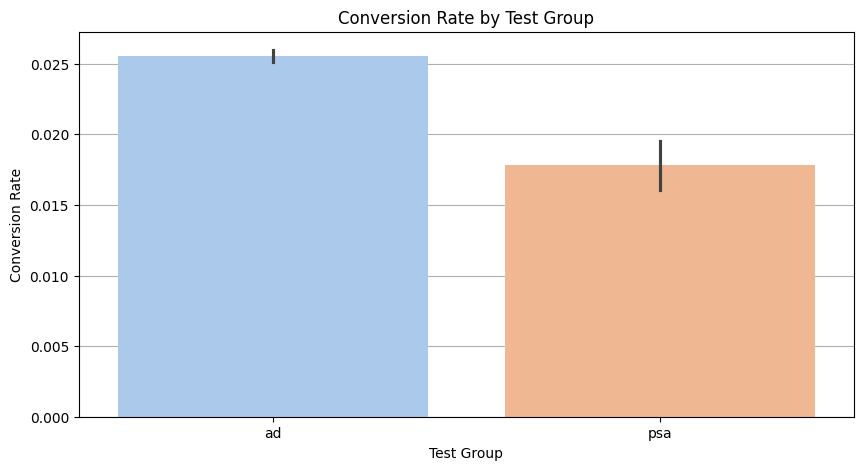

In [33]:
plt.figure(figsize=(10, 5))

sns.barplot(x='test group', y='converted', hue='test group', data=df, errorbar=('ci', 95), palette='pastel', legend=False)

plt.xlabel('Test Group')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Test Group')
plt.grid(which='major', axis='y')
plt.gca().set_axisbelow(True)

plt.show()

It seems certain that conversion rates are diferrent between the groups. Let's formally test if the conversion rate in ad group statistically different from that of in psa group. Since we are comparing two groups, and have large number of observations, we will be using Z test. Z-test for this case whould be the best option, but since the question is very important re whether or not ads help wityh conversion rate we are going to test also with Chi^2.

In [ ]:
# Examining  the statistical difference of conversion in groups 'ad' and 'psa' with Z test proportions.

# Count number of conversions (users who purchased)
X_ad  = df[df['test group'] == 'ad']['converted'].sum()  # Total conversions in Ad group
X_psa = df[df['test group'] == 'psa']['converted'].sum()  # Total conversions in PSA group

# Count total users in each group
n_ad  = df[df['test group'] == 'ad'].shape[0]  # Total users in Ad group
n_psa = df[df['test group'] == 'psa'].shape[0]  # Total users in PSA group

# Prepare input for Z-test
converted = [X_ad, X_psa]  # Number of conversions in Ad & PSA groups
total = [n_ad, n_psa]  # Total users in Ad & PSA groups

# Perform a two-proportion Z-test
z_stat, p_value = proportions_ztest(converted, total)

print(f"Z-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Check significance
if p_value < 0.05:
    print("Result: The conversion rates are significantly different (Ads have an impact).")
else:
    print("Result: No significant difference (Ads may not be driving conversions).")

Z-Statistic: 7.3701
P-Value: 0.0000
Result: The conversion rates are significantly different (Ads have an impact).


In [36]:

# Create the contingency table (observed values)
observed = np.array([
    [X_ad, n_ad - X_ad],  # Ad group: converted vs. not converted
    [X_psa, n_psa - X_psa]  # PSA group: converted vs. not converted
])

# Perform Chi-Square Test
chi2_stat, p_value, _, _ = stats.chi2_contingency(observed)

# Display results
print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-Value: {p_value:.10f}")

# Interpretation
if p_value < 0.05:
    print("Result: There is a significant difference in conversion rates (Ads have an impact).")
else:
    print("Result: No significant difference in conversion rates.")


Chi-Square Statistic: 54.0058
P-Value: 0.0000000000
Result: There is a significant difference in conversion rates (Ads have an impact).


In [71]:
# so now we know that conversion rates are statistically different!
#let's have a look at the type II error and perhaps size of the effect (initally using Cohen h)
# Count conversions and total observations in each group
conversion_counts = df.groupby('test group')['converted'].sum()
total_counts = df.groupby('test group')['converted'].count()

# Calculate observed conversion rates
p1 = conversion_counts['psa'] / total_counts['psa']  # Conversion rate in PSA group
p2 = conversion_counts['ad'] / total_counts['ad']    # Conversion rate in AD group


# Compute effect size (Cohen's h for proportions)
effect_size = proportion_effectsize(p2, p1)

# Compute power using observed sample sizes
analysis = NormalIndPower()
actual_power = analysis.solve_power(effect_size, alpha=0.05, nobs1=total_counts['psa'], ratio=total_counts['ad'] / total_counts['psa'])

print(f"Observed Conversion Rate (PSA): {p1:.4f}")
print(f"Observed Conversion Rate (AD): {p2:.4f}")
print(f"Effect Size (Cohen's h): {effect_size:.4f}")
print(f"Achieved Power: {actual_power:.4f}")

Observed Conversion Rate (PSA): 0.0179
Observed Conversion Rate (AD): 0.0255
Effect Size (Cohen's h): 0.0530
Achieved Power: 1.0000


Achieved Power = 1 indicates no room for type II error (false negative), which is good.

Cohen h = 0.053 means minipal practical effect of ads on conversion rate. However, if we think a bit it is not true - the effect of ads is huge! conversion rate increases from 1.8% to 2.6% which is more than 40% increase. The qeustion is why Cohen h shows very low practical effect. Th answer is that Cohen h works not well on small scale, if we had 10% in psa and 14% (40% more) in ad group, the cohen h would be higher.

Perhaps we should use another metric to show effect. Let's use Odds Ratio (OR) and Risk Ratio (RR)

Since we are positive now that ads do help to increase conversion rate, let's dig deeper and examine the most effective way to use ads.

In [ ]:
# Compute Odds Ratio (OR)
#Calculates Odds Ratio (OR): How much more likely a conversion is in the ad group.
#Calculates Risk Ratio (RR): How much higher the conversion rate is in the ad group.

odds1 = p1 / (1 - p1)  # Odds of conversion in PSA group
odds2 = p2 / (1 - p2)  # Odds of conversion in AD group
odds_ratio = odds2 / odds1

# Compute Risk Ratio (RR)
risk_ratio = p2 / p1

# Print results
print(f"Odds Ratio (OR): {odds_ratio:.4f}")
print(f"Risk Ratio (RR): {risk_ratio:.4f}")

Odds Ratio (OR): 1.4421
Risk Ratio (RR): 1.4309


So, the effect of ads is meaningful.

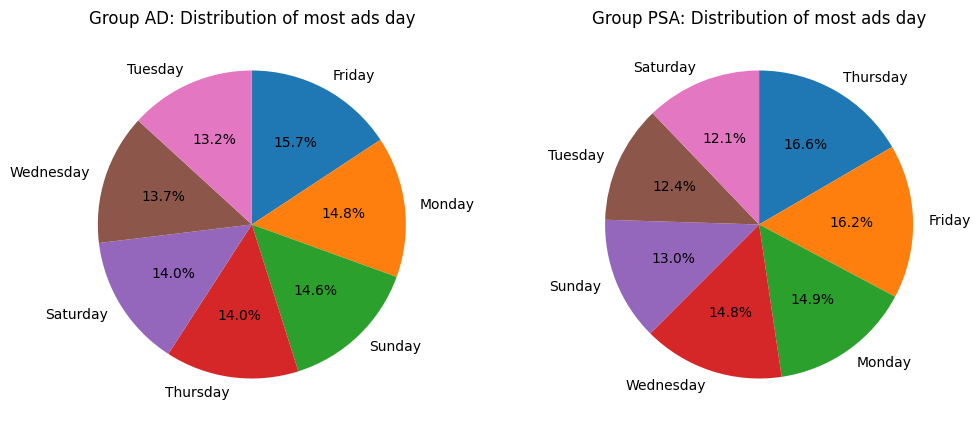

In [45]:
# let's examine how the ads are seen intependently in ad/psa group

# Group AD
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
group_counts = df[df['test group']=='ad']['most ads day'].value_counts()
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Group AD: Distribution of most ads day')

# Group PSA
plt.subplot(1, 2, 2)
group_counts = df[df['test group']=='psa']['most ads day'].value_counts()
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Group PSA: Distribution of most ads day')
plt.show()


Main take aways: 1) groups see ads in different patterns (and it might affect conversion rates difference between the group). 2) in AD group the most ads day is Friday.

Now let's have a look at most ads hour patterns

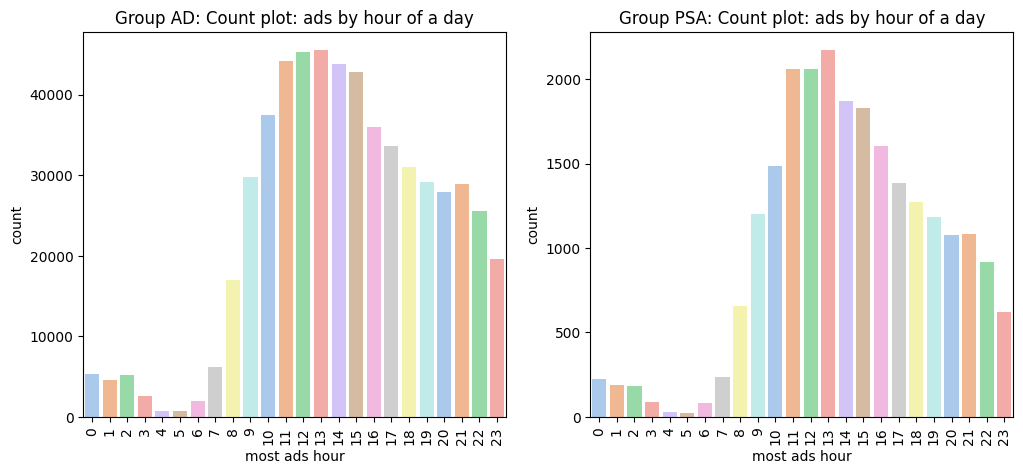

In [55]:
# distribution of ads by hour of a day (seprately for ad and psa groups)
hour_order = list(range(24))  # Ensures the X-axis always runs from 0 to 23


plt.figure(figsize=(12, 5))

# Group AD
plt.subplot(1, 2, 1)
sns.countplot(x='most ads hour', data=df[df['test group']=='ad'], order=hour_order, palette='pastel', hue='most ads hour', legend = False)
plt.title(f'Group AD: Count plot: ads by hour of a day')
plt.xticks(rotation=90)

# Group psa
plt.subplot(1, 2, 2)
sns.countplot(x='most ads hour', data=df[df['test group']=='psa'], order=hour_order, palette='pastel', hue='most ads hour', legend = False)
plt.title(f'Group PSA: Count plot: ads by hour of a day')
plt.xticks(rotation=90)

plt.show()

Both groups are seeing the ads/psa in the about the same pattern.

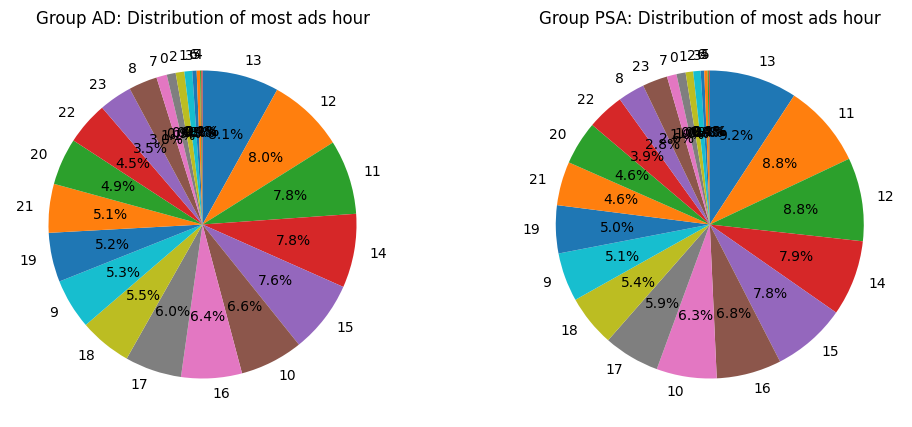

In [46]:
# let's examine how the ads are seen by hours (separately in ad/psa groups)

# Group AD
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
group_counts = df[df['test group']=='ad']['most ads hour'].value_counts()
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Group AD: Distribution of most ads hour')

# Group PSA
plt.subplot(1, 2, 2)
group_counts = df[df['test group']=='psa']['most ads hour'].value_counts()
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Group PSA: Distribution of most ads hour')
plt.show()

Users have very similar patterns of seeing the ads/psa by hour of the day. Most ads hours are 10-16 (about 50% ads seen total)

Now, let's focus on Conversion rates and how it depends on 1)day of the week, 2) time of the day (most ads seen).

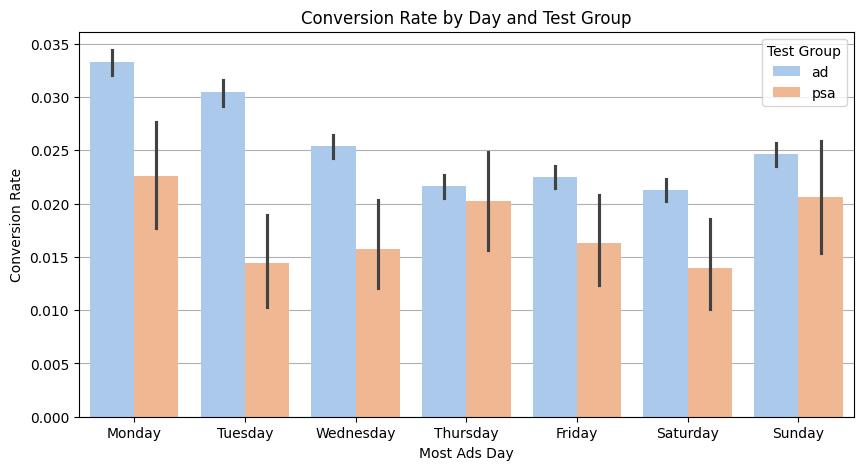

In [37]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))

sns.barplot(x='most ads day', y='converted', hue='test group', 
            data=df, errorbar=('ci', 95), palette='pastel', order=weekday_order)  # Ensure correct order

plt.xlabel('Most Ads Day')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Day and Test Group')

plt.legend(title='Test Group', loc='upper right', bbox_to_anchor=(1, 1))  # Adjusted legend position
plt.grid(which='major', axis='y')
plt.gca().set_axisbelow(True)

plt.show()


Interesting observation.<br>

Group AD:<br>
&emsp;most ads day: Friday. Lowest is Tuesday.<br>
&emsp;day w/ highest CR: Monday and Tuesday! while Friday is among lowest CR.<br>
&emsp;The company should decrease ads on Friday and show them definitely more on Tusday!<br>


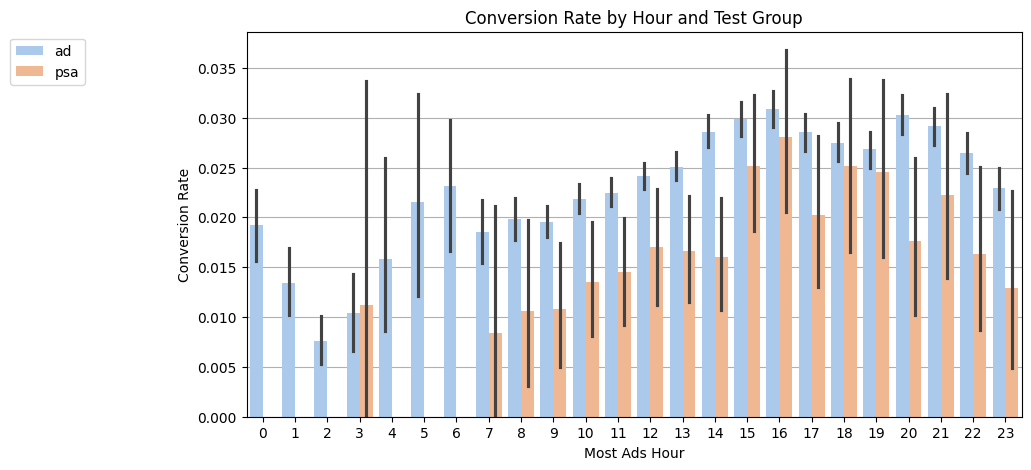

In [14]:
plt.figure(figsize=(10, 5))

sns.barplot(x='most ads hour', y='converted', hue='test group', data=df, errorbar=('ci', 95), palette = 'pastel')  # CI will be computed!

plt.xlabel('Most Ads Hour')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Hour and Test Group')
plt.legend(title='Test Group', loc='upper right', bbox_to_anchor=(-0.2, 1))
plt.legend(loc='upper right', bbox_to_anchor=(-0.2, 1))
plt.grid(which='major', axis='y')
plt.gca().set_axisbelow(True)

plt.show()

The highest conversion rate:<br>
&emsp;&emsp;&emsp;ad group:  day is Monday, hours are 15, 16, 20<br>
&emsp;&emsp;&emsp;psa group: day is Monday, hours are 15, 16, 18, 19<br>

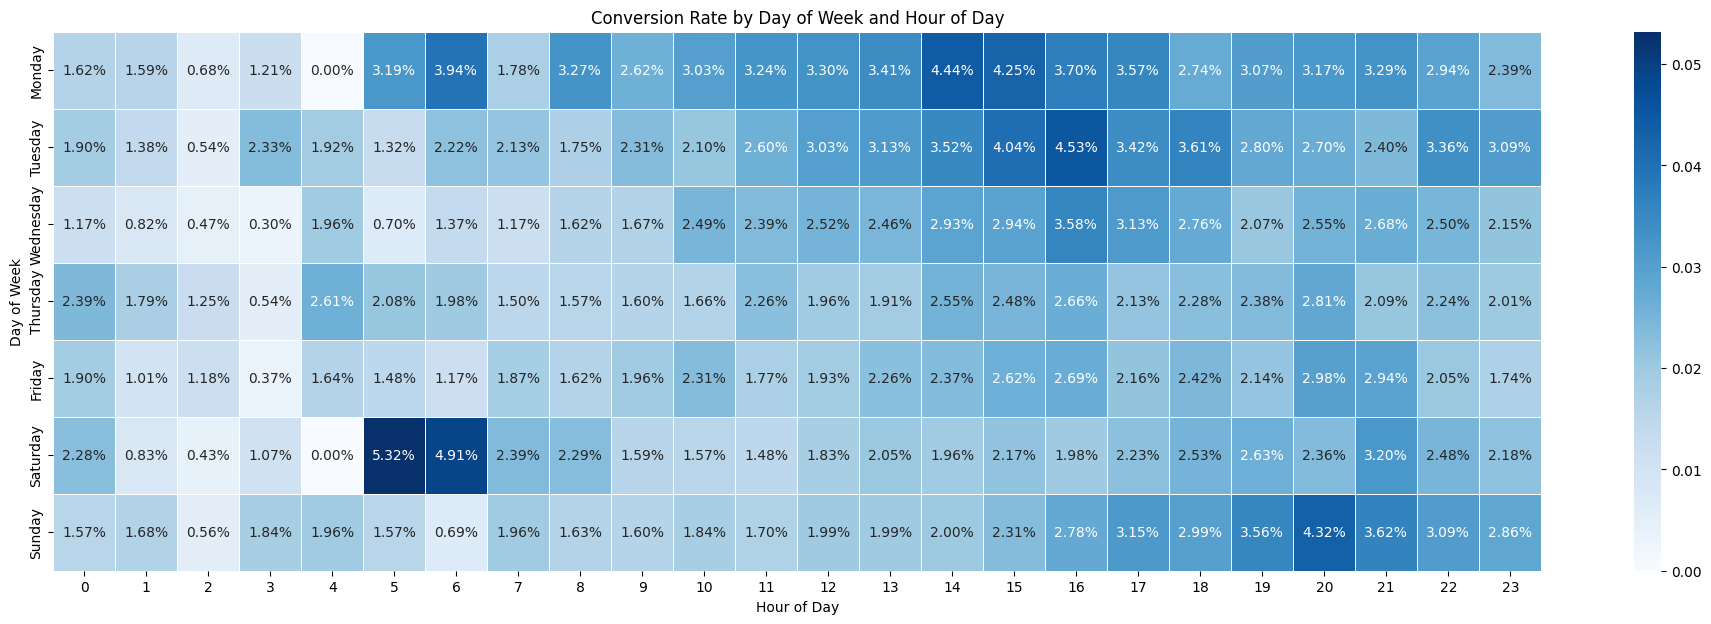

In [15]:
# Group by day of the week and hour, calculating conversion rate
heatmap_data = df.groupby(['most ads day', 'most ads hour'])['converted'].mean().reset_index()

# Pivot the data for heatmap format
heatmap_pivot = heatmap_data.pivot(index='most ads day', columns='most ads hour', values='converted')

# Sort the days of the week correctly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_pivot = heatmap_pivot.reindex(day_order)

# Plot heatmap
plt.figure(figsize=(24, 7))
sns.heatmap(heatmap_pivot, cmap='Blues', annot=True, fmt=".2%", linewidths=0.5)

# Labels and title
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.title("Conversion Rate by Day of Week and Hour of Day")

plt.show()

interesting, why on Saturday morning at 5 and 6 am conversion rates are so high?

C:\Users\Andrey Kobelev\AppData\Local\Temp\ipykernel_8588\1477253929.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_rates_ad = df[df['test group']=='ad'].groupby('bucket ad')['converted'].mean().reset_index() # here mean() will be mathematically the same as conversion ratio! 1*count_1 + 0*count_0 = 1*count_1 and then divide it by (count_1+count_0)
C:\Users\Andrey Kobelev\AppData\Local\Temp\ipykernel_8588\1477253929.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_rates_psa = df[df['test group']=='psa'].groupby('bucket psa')['converted'].mean().reset_index() # here mean() will b

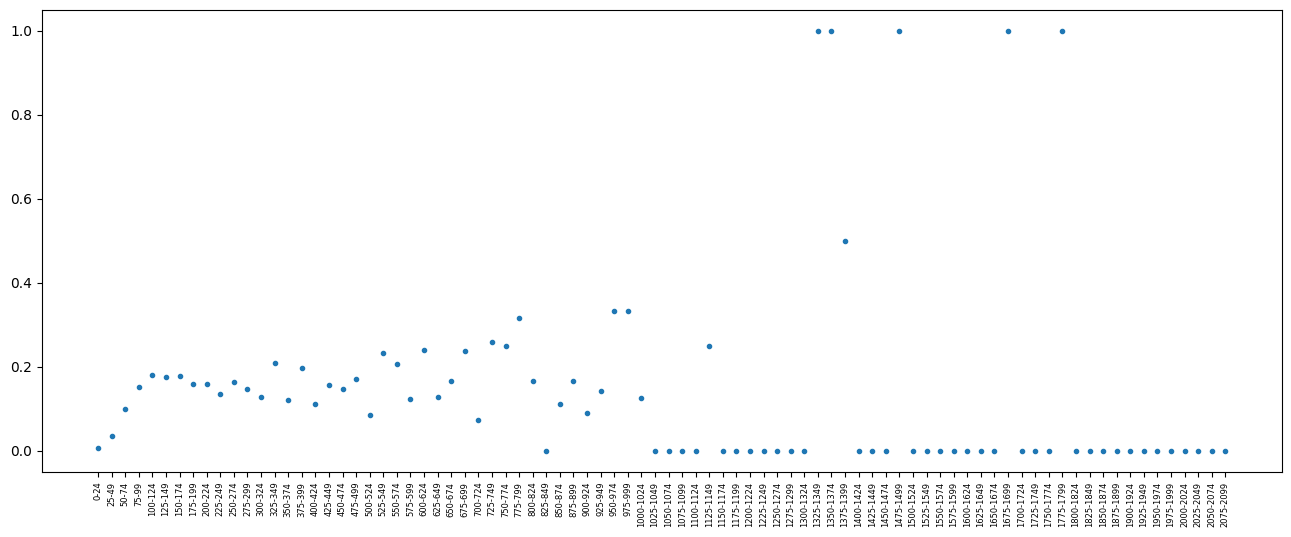

In [ ]:

# Define bucket edges (from 0 to 2500, step=25)
bins = list(range(0, 2101, 25))  # Ensures the last bin includes 2500
labels = [f"{i}-{i+24}" for i in bins[:-1]]  # Creates labels like '0-24', '25-49', etc.

# Create buckets
df['bucket ad']     = pd.cut(df[df['test group']=='ad']['total ads'], bins=bins, labels=labels, include_lowest=True)
df['bucket psa']    = pd.cut(df[df['test group']=='psa']['total ads'], bins=bins, labels=labels, include_lowest=True)

# Calculate conversion rate per bucket
conversion_rates_ad = df[df['test group']=='ad'].groupby('bucket ad')['converted'].mean().reset_index() # here mean() will be mathematically the same as conversion ratio! 1*count_1 + 0*count_0 = 1*count_1 and then divide it by (count_1+count_0)
conversion_rates_ad['converted'] = conversion_rates_ad['converted'].fillna(0)

conversion_rates_psa = df[df['test group']=='psa'].groupby('bucket psa')['converted'].mean().reset_index() # here mean() will be mathematically the same as conversion ratio! 1*count_1 + 0*count_0 = 1*count_1 and then divide it by (count_1+count_0)
conversion_rates_psa['converted'] = conversion_rates_psa['converted'].fillna(0)

x=conversion_rates_ad['bucket ad']
y=conversion_rates_ad['converted']
plt.figure(figsize=(16, 6))
plt.scatter(x, y, label="test group ad", marker='.')
plt.xticks(rotation=90, fontsize=6)
plt.show()

C:\Users\Andrey Kobelev\AppData\Local\Temp\ipykernel_8588\1012202700.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_rates_ad = df[df['test group']=='ad'].groupby('bucket ad')['converted'].mean().reset_index() # here mean() will be mathematically the same as conversion ratio! 1*count_1 + 0*count_0 = 1*count_1 and then divide it by (count_1+count_0)
C:\Users\Andrey Kobelev\AppData\Local\Temp\ipykernel_8588\1012202700.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_rates_psa = df[df['test group']=='psa'].groupby('bucket psa')['converted'].mean().reset_index() # here mean() will b

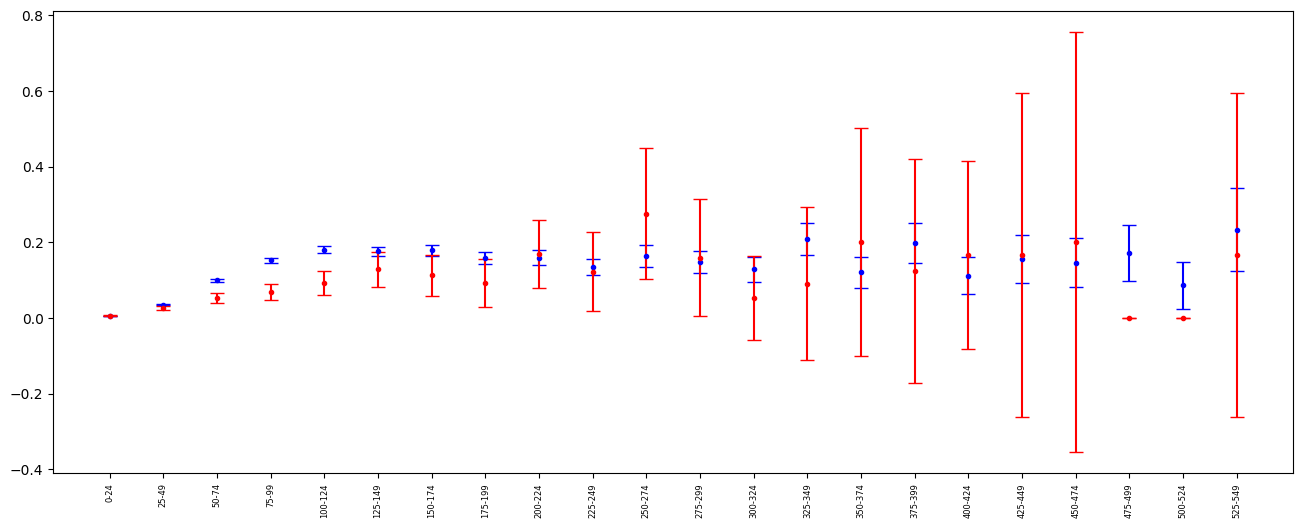

In [ ]:
# Define bucket edges (from 0 to 2500, step=25)
bins = list(range(0, 551, 25))  # Ensures the last bin includes 2500
labels = [f"{i}-{i+24}" for i in bins[:-1]]  # Creates labels like '0-24', '25-49', etc.

# Create buckets
df['bucket ad']     = pd.cut(df[df['test group']=='ad']['total ads'], bins=bins, labels=labels, include_lowest=True)
df['bucket psa']    = pd.cut(df[df['test group']=='psa']['total ads'], bins=bins, labels=labels, include_lowest=True)

# Calculate conversion rate per bucket
conversion_rates_ad = df[df['test group']=='ad'].groupby('bucket ad')['converted'].mean().reset_index() # here mean() will be mathematically the same as conversion ratio! 1*count_1 + 0*count_0 = 1*count_1 and then divide it by (count_1+count_0)
conversion_rates_ad['converted'] = conversion_rates_ad['converted'].fillna(0)

conversion_rates_psa = df[df['test group']=='psa'].groupby('bucket psa')['converted'].mean().reset_index() # here mean() will be mathematically the same as conversion ratio! 1*count_1 + 0*count_0 = 1*count_1 and then divide it by (count_1+count_0)
conversion_rates_psa['converted'] = conversion_rates_psa['converted'].fillna(0)

# Compute conversion rate + standard error (SE)
df_ad_ci = df.groupby('bucket ad')['converted'].agg(['mean', 'count', 'std']).reset_index()
df_ad_ci['se'] = df_ad_ci['std'] / np.sqrt(df_ad_ci['count'])  # Standard Error
df_ad_ci['ci'] = df_ad_ci['se'] * stats.t.ppf(0.975, df_ad_ci['count'] - 1)  # 95% CI

df_psa_ci = df.groupby('bucket psa')['converted'].agg(['mean', 'count', 'std']).reset_index()
df_psa_ci['se'] = df_psa_ci['std'] / np.sqrt(df_psa_ci['count'])  # Standard Error
df_psa_ci['ci'] = df_psa_ci['se'] * stats.t.ppf(0.975, df_psa_ci['count'] - 1)  # 95% CI



x_ad    = df_ad_ci['bucket ad']
y_ad    = df_ad_ci['mean']
x_psa    = df_psa_ci['bucket psa']
y_psa    = df_psa_ci['mean']

plt.figure(figsize=(16, 6))
#plt.scatter(x, y, label="test group ad", marker='.')
plt.errorbar(x_ad, y_ad, yerr=df_ad_ci['ci'], fmt='.', color='blue', capsize=5,marker='.')
plt.errorbar(x_psa, y_psa, yerr=df_psa_ci['ci'], fmt='.', color='red', capsize=5,marker='.')
plt.xticks(rotation=90, fontsize=6)
#coeffs = np.polyfit(x, y, 2)  # 2nd-degree polynomial
#trend = np.poly1d(coeffs)
#plt.plot(x, trend(x), color="green", label="Polynomial Trend")

#plt.plot(conversion_rates_ad['bucket ad'], conversion_rates_ad['converted'], marker='.', linestyle='-', color='red', label="Line Chart")
#plt.plot(conversion_rates_psa['bucket psa'], conversion_rates_psa['converted'], marker='.', linestyle='-', color='blue', label="Line Chart")
plt.show()



to improve conversion rates, it is good idea to show ads in the range of above 100 times. After 100 shown ads, the conversion rate level is about the same but valotility increases. Pehaps target number of ads shown to a user should about 200. it could be more but after 200 the density perhaps shold not be high... Explanations: perhaps people decide to buy or not buy before they see the ad for 200 times.

In [64]:
# Add intercept
df['Intercept'] = 1

# Create dummy variables for weekdays
dummies_weekday = pd.get_dummies(df['most ads day'], prefix='day').astype(int)
dummies_weekday = dummies_weekday.apply(lambda x: x - (x.name == 'Friday'))  # we gonna use Friday as reference hour since it has lowest count most ads day

# Create dummy variables for weekdays
dummies_hour = pd.get_dummies(df['most ads hour'], prefix='h').astype(int)
dummies_hour = dummies_hour.apply(lambda x: x - (x.name == '2'))  # we gonna use 2am as reference hour since it has lowest count of most ads hour




# Concatenate dummy variables with the original DataFrame
df_w_dummies = pd.concat([df, dummies_weekday, dummies_hour], axis=1)
df_w_dummies['Saturday_5'] = dummies_weekday['day_Saturday']*dummies_hour['h_5']
df_w_dummies['Saturday_6'] = dummies_weekday['day_Saturday']*dummies_hour['h_6']
#print(df_w_dummies)

# Filter only 'ad' group
df_w_dummies_ad = df_w_dummies[df_w_dummies['test group']=='ad']
#print(df_w_dummies_ad)



# Fit Logistic Regression
model = sm.Logit(
                df_w_dummies_ad['converted'], 
                df_w_dummies_ad[[
                    'Intercept', 
                    'total ads', 
                    'day_Monday', 'day_Tuesday', 'day_Wednesday', 'day_Friday', 'day_Saturday', 'day_Sunday',
                    'h_0','h_1','h_3','h_4','h_5','h_6','h_7','h_8','h_9','h_10','h_11','h_12', 'h_13','h_14','h_15','h_16','h_17','h_18','h_19','h_20','h_21','h_22','h_23',
                    'Saturday_5', 'Saturday_6'
                    ]])
result = model.fit()

# Print results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.109182
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               564577
Model:                          Logit   Df Residuals:                   564544
Method:                           MLE   Df Model:                           32
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                 0.08176
Time:                        20:35:50   Log-Likelihood:                -61641.
converged:                       True   LL-Null:                       -67130.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.5557      0.175    -31.824      0.000      -5.898      -5.214
total ads         0.

Final thoughts:<br>
1. ads do increase(statistically significant) conversion rate. Almost 44% difference in conversion rates between ad and psa groups (2.55% vs 1.8%).
2. Less ads should be shown on Fridays and more on Tuesdays. The best times to show ads is from 10am and till midnight. More specifically 2pm-5pm and then 8-10pm.
3. To increase conversion ratio, the user shall see ads above 100 times but perhaps below 200. after 200 - not clear.
3. Highest conversion rates on heatmap: Saturday mornings  (5 and 6 am) are not statistically significant. perhaps more data is necessary.... looks strange.
4. intercept is conversion rate no ads seens, day: Friday, time: about 2am  p = e^(-5.5)/(e^(1+-5.5))=0.38% conversion rate
5. seeing 1 ad increases conversion rate by about 1%: e^*(0.0103)/(1+e^(0.0103))=1.010
5. seeing ad on monday will increse conversion rate by 51%!: e^*(0.414)/(1+e^(0.414))=1.513
6. ad at 4pm will increse conversion rate 4 times!: e^*(1.6266)/(1+e^(1.6266))=5.09